Imports

In [30]:
import pickle
import gzip
import numpy as np
#import os
#from PIL import Image as im
import cv2
#import pandas as pd
import matplotlib.pyplot as plt
#import torchdata as td
#from torchmetrics.functional import jaccard_index
#from tensorflow.keras.utils import to_categorical
from PIL import Image as im
from skimage.measure import label, regionprops
#from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow import keras

#from keras import backend as K
from tensorflow.keras import layers
from sklearn.model_selection import KFold

In [31]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

## Mitral U-Net

In [32]:
def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding="same")(x)#kernel_initializer = "he_normal"
   x = layers.BatchNormalization()(x)
   x = layers.ReLU()(x)
   x = layers.Conv2D(n_filters, 3, padding="same")(x)#kernel_initializer = "he_normal"
   x = layers.BatchNormalization()(x)
   x = layers.ReLU()(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   #p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 2, 2, padding="valid")(x)
   x = layers.concatenate([x, conv_features])
   #x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x

In [33]:
def get_model(img_size):
    inputs = layers.Input(shape=img_size+(1,))
    
    f1, p1 = downsample_block(inputs, 16)
    f2, p2 = downsample_block(p1, 32)
    f3, p3 = downsample_block(p2, 64)
    #f4, p4 = downsample_block(p3, 256)
    
    #bottleneck = double_conv_block(p4, 512)
    bottleneck = double_conv_block(p3, 128)
    
    #u6 = upsample_block(bottleneck, f4, 256)
    u7 = upsample_block(bottleneck, f3, 64)
    u8 = upsample_block(u7, f2, 32)
    u9 = upsample_block(u8, f1, 16)

    outputs = layers.Conv2D(1, 1, padding="valid", activation = "sigmoid")(u9)
    
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    
    return unet_model

## Box U-Net

In [48]:
def double_conv_block_box(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding="same")(x)#kernel_initializer = "he_normal"
   x = layers.BatchNormalization()(x)
   x = layers.ReLU()(x)
   x = layers.Conv2D(n_filters, 3, padding="same")(x)#kernel_initializer = "he_normal"
   x = layers.BatchNormalization()(x)
   x = layers.ReLU()(x)
   return x

def downsample_block_box(x, n_filters):
   f = double_conv_block_box(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   #p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block_box(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 2, 2, padding="valid")(x)
   x = layers.concatenate([x, conv_features])
   #x = layers.Dropout(0.3)(x)
   x = double_conv_block_box(x, n_filters)
   return x

In [49]:
def get_model_box(img_size):
    inputs = layers.Input(shape=img_size+(1,))
    
    f1, p1 = downsample_block_box(inputs, 16)
    f2, p2 = downsample_block_box(p1, 32)
    f3, p3 = downsample_block_box(p2, 64)
    #f4, p4 = downsample_block(p3, 256)
    
    #bottleneck = double_conv_block(p4, 512)
    bottleneck = double_conv_block_box(p3, 128)
    
    #u6 = upsample_block(bottleneck, f4, 256)
    u7 = upsample_block_box(bottleneck, f3, 64)
    u8 = upsample_block_box(u7, f2, 32)
    u9 = upsample_block_box(u8, f1, 16)

    outputs = layers.Conv2D(1, 1, padding="valid", activation = "sigmoid")(u9)
    
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    
    return unet_model

## Data Preparation

In [34]:
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")
samples = load_zipped_pickle("sample.pkl")

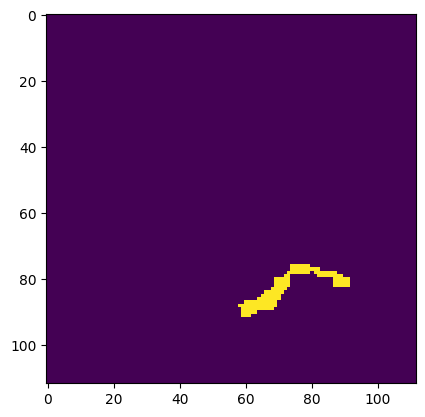

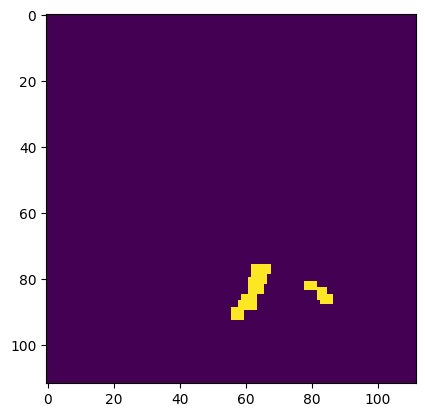

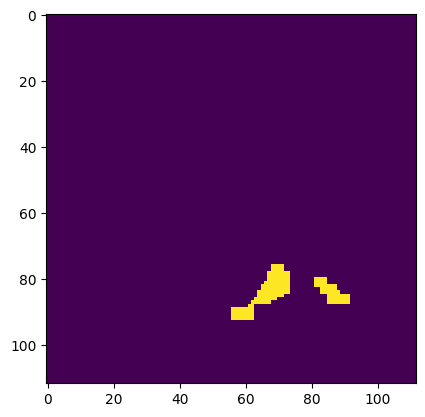

In [84]:
for i in range(3):
    plt.imshow(train_data[0]["label"][:,:,train_data[0]["frames"][i]])
    plt.show()

### Mitral

In [37]:
x_train = []
y_train = []
for d in train_data:
    for i in d["frames"]:
        x_train.append(cv2.resize(d["video"][:,:,i], dsize=(360, 360)))
        y_train.append(cv2.resize(255 * d["label"][:,:,i].astype(np.ubyte), dsize=(360, 360)))

x_train = np.expand_dims(np.array(x_train, dtype=np.single), 3)
y_train = np.expand_dims(np.array(y_train, dtype=np.single), 3)

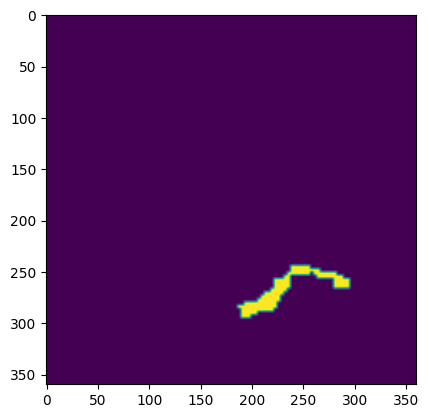

In [20]:
plt.imshow(y_train[0,:,:,0])
plt.show()

### Box

In [87]:
y_train_box = []
for dic in train_data:
    y_train_box.append(cv2.resize(255 * dic["box"].astype(np.ubyte), dsize=(360, 360)))

65


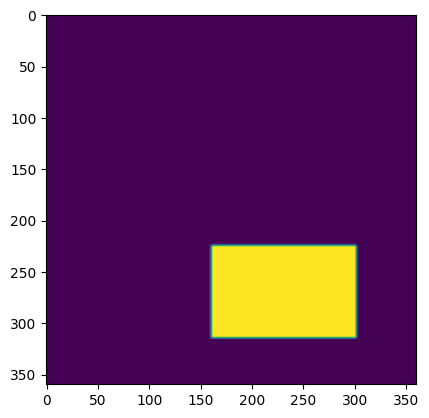

In [88]:
print(len(y_train_box))
plt.imshow(y_train_box[0])
plt.show()


## Training

### Fix seed

In [68]:
# fix seed
seed = 1
np.random.seed(seed)

### Mitral

In [93]:
EPOCHS = 8
BATCH_SIZE = 4
fold_no = 0
for train_idx, test_idx in KFold(n_splits=5, shuffle=True).split(y_train):
    
    fold_no += 1
    print('------------------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    print('------------------------------------------------------------------------------------')
    
    keras.backend.clear_session()
    model = get_model((360, 360))
    model.summary()
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        #loss=keras.losses.CategoricalCrossentropy(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name='accuracy')]
    )

    model.fit(
        x_train[train_idx],
        y_train[train_idx],
        validation_data=(x_train[test_idx], y_train[test_idx]),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=2
    )
    
    #scores = model.evaluate(samples[test_idx], labels[test_idx], verbose=0)
    #f1 = f1_score(np.argmax(labels[test_idx], axis=1), np.argmax(model.predict(samples[test_idx]), axis=1), average='micro')
    #print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; f1_score of {f1}')
    break

------------------------------------------------------------------------------------
Training for fold 1 ...
------------------------------------------------------------------------------------
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 360, 360, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 360, 360, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  

### Box

In [ ]:
EPOCHS = 8
BATCH_SIZE = 4
fold_no = 0
for train_idx, test_idx in KFold(n_splits=5, shuffle=True).split(y_train):
    
    fold_no += 1
    print('------------------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    print('------------------------------------------------------------------------------------')
    
    keras.backend.clear_session()
    model = get_model_box((360, 360))
    model.summary()
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        #loss=keras.losses.CategoricalCrossentropy(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name='accuracy')]
    )

    model.fit(
        x_train[train_idx],
        y_train[train_idx],
        validation_data=(x_train[test_idx], y_train[test_idx]),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=2
    )
    
    #scores = model.evaluate(samples[test_idx], labels[test_idx], verbose=0)
    #f1 = f1_score(np.argmax(labels[test_idx], axis=1), np.argmax(model.predict(samples[test_idx]), axis=1), average='micro')
    #print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; f1_score of {f1}')
    break

## Prediction

### Mitral

In [94]:
pred = model.predict(x_train[test_idx])
pred = np.squeeze(pred)

TH = 0.999
NB_OF_AREAS = 4
intersection = 0
union = 0
fehlt = 0
for i in range(39):
    idx = test_idx[i]
    ff = train_data[idx//3]["frames"][idx%3]
    gt = train_data[idx//3]["label"][:,:,ff]
    gt_img = im.fromarray(gt)
    
    pp = cv2.resize(255 * pred[i,:,:], dsize=gt.shape[::-1])
    pp = pp > (255 * TH)    
    pred_img = im.fromarray(pp)
    
    lab = label(pp)
    rps = regionprops(lab)
    area_idx = np.argsort([r.area for r in rps])[::-1]
    new_pp = np.zeros_like(pp)
    for j in area_idx[:NB_OF_AREAS]:
        new_pp[tuple(rps[j].coords.T)] = True
    new_pred_img = im.fromarray(new_pp)
    
    fehlt += np.count_nonzero(np.logical_and(gt, np.logical_not(new_pp)))
    intersection += np.count_nonzero(np.logical_and(gt, new_pp))
    union += np.count_nonzero(np.logical_or(gt, new_pp))
    
print(fehlt)
print("score:")
print(intersection / union)

#pred = im.fromarray((np.squeeze(model.predict(x_train[16:17]))>0.8))
#gt = im.fromarray(cv2.resize(255 * train_data[5]["label"][:,:,51].astype(np.ubyte), dsize=(360, 360)))

2/2 [==============================] - 2s 397ms/step
1553
score:
0.07123296288059021


### Box

In [ ]:
pred = model.predict(x_train[test_idx])
pred = np.squeeze(pred)

TH = 0.999
NB_OF_AREAS = 4
intersection = 0
union = 0
fehlt = 0
for i in range(39):
    idx = test_idx[i]
    ff = train_data[idx//3]["frames"][idx%3]
    gt = train_data[idx//3]["label"][:,:,ff]
    gt_img = im.fromarray(gt)
    
    pp = cv2.resize(255 * pred[i,:,:], dsize=gt.shape[::-1])
    pp = pp > (255 * TH)    
    pred_img = im.fromarray(pp)
    
    lab = label(pp)
    rps = regionprops(lab)
    area_idx = np.argsort([r.area for r in rps])[::-1]
    new_pp = np.zeros_like(pp)
    for j in area_idx[:NB_OF_AREAS]:
        new_pp[tuple(rps[j].coords.T)] = True
    new_pred_img = im.fromarray(new_pp)
    
    fehlt += np.count_nonzero(np.logical_and(gt, np.logical_not(new_pp)))
    intersection += np.count_nonzero(np.logical_and(gt, new_pp))
    union += np.count_nonzero(np.logical_or(gt, new_pp))
    
print(fehlt)
print("score:")
print(intersection / union)

#pred = im.fromarray((np.squeeze(model.predict(x_train[16:17]))>0.8))
#gt = im.fromarray(cv2.resize(255 * train_data[5]["label"][:,:,51].astype(np.ubyte), dsize=(360, 360)))